In [1]:

import numpy as np
import pandas as pd
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

print("✓ All dependencies installed!")

✓ All dependencies installed!


In [2]:
print("Downloading CIFAR-10 dataset...")

transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

X_train = np.array([img.numpy().transpose(1, 2, 0) * 255 for img, _ in trainset]).astype(np.float32)
y_train = np.array([label for _, label in trainset])

X_test = np.array([img.numpy().transpose(1, 2, 0) * 255 for img, _ in testset]).astype(np.float32)
y_test = np.array([label for _, label in testset])

print("✓ Dataset loaded!")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")


100%|██████████| 170M/170M [00:03<00:00, 44.9MB/s]


✓ Dataset loaded!
  X_train shape: (50000, 32, 32, 3)
  y_train shape: (50000,)
  X_test shape: (10000, 32, 32, 3)
  y_test shape: (10000,)


In [3]:
def create_stratified_subsets(
    X, y,
    fractions=[0.05, 0.10, 0.25, 0.50, 0.75, 1.0],
    random_seed=42
):
    subsets = {}
    np.random.seed(random_seed)

    for frac in fractions:
        if frac == 1.0:
            subsets[frac] = (X.copy(), y.copy())
        else:
            X_sub, _, y_sub, _ = train_test_split(
                X, y,
                train_size=frac,
                stratify=y,
                random_state=random_seed
            )
            subsets[frac] = (X_sub, y_sub)
        print(
            f"Fraction {frac*100:5.1f}%: "
            f"{len(subsets[frac][1]):5d} samples, "
            f"class dist: {np.bincount(subsets[frac][1])}"
        )
    return subsets

print("Creating stratified subsets...")
subsets = create_stratified_subsets(X_train, y_train)
print("✓ Subsets created!")


Creating stratified subsets...
Fraction   5.0%:  2500 samples, class dist: [250 250 250 250 250 250 250 250 250 250]
Fraction  10.0%:  5000 samples, class dist: [500 500 500 500 500 500 500 500 500 500]
Fraction  25.0%: 12500 samples, class dist: [1250 1250 1250 1250 1250 1250 1250 1250 1250 1250]
Fraction  50.0%: 25000 samples, class dist: [2500 2500 2500 2500 2500 2500 2500 2500 2500 2500]
Fraction  75.0%: 37500 samples, class dist: [3750 3750 3750 3750 3750 3750 3750 3750 3750 3750]
Fraction 100.0%: 50000 samples, class dist: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
✓ Subsets created!


In [4]:
def normalize_data(X_train_subset, X_test):
    mean = X_train_subset.mean(axis=(0, 1, 2), keepdims=True)
    std = X_train_subset.std(axis=(0, 1, 2), keepdims=True)
    X_train_norm = (X_train_subset - mean) / (std + 1e-8)
    X_test_norm = (X_test - mean) / (std + 1e-8)
    return X_train_norm, X_test_norm

print("Normalizing data...")
normalized_subsets = {}

for frac, (X_sub, y_sub) in subsets.items():
    X_train_norm, X_test_norm = normalize_data(X_sub, X_test)
    X_train_flat = X_train_norm.reshape(X_train_norm.shape[0], -1)
    X_test_flat = X_test_norm.reshape(X_test_norm.shape[0], -1)

    normalized_subsets[frac] = {
        "X_train": X_train_flat,
        "X_train_3d": X_train_norm,
        "X_test": X_test_flat,
        "X_test_3d": X_test_norm,
        "y_train": y_sub,
        "y_test": y_test
    }

print(f"✓ Data normalized for {len(normalized_subsets)} subsets")


Normalizing data...
✓ Data normalized for 6 subsets


In [5]:
class CIFAR10CNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # 32→16

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # 16→8

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)  # 8→4

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu1(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

print("✓ CNN architecture defined")


✓ CNN architecture defined


In [6]:
def train_logistic_regression(X_train, y_train, X_test, y_test, max_iter=1000):
    start = time.time()
    model = LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=max_iter,
        random_state=42
    )
    model.fit(X_train, y_train)
    train_time = time.time() - start
    acc = accuracy_score(y_test, model.predict(X_test))
    return model, acc, train_time

def train_random_forest(X_train, y_train, X_test, y_test, n_trees=100, seed=42):
    start = time.time()
    model = RandomForestClassifier(
        n_estimators=n_trees,
        random_state=seed,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    train_time = time.time() - start
    acc = accuracy_score(y_test, model.predict(X_test))
    return model, acc, train_time

def train_knn(X_train, y_train, X_test, y_test, k=5):
    start = time.time()
    model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    model.fit(X_train, y_train)
    train_time = time.time() - start
    acc = accuracy_score(y_test, model.predict(X_test))
    return model, acc, train_time

def train_cnn_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    return total_loss / len(loader), correct / total

def evaluate_cnn(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

def train_cnn(X_train, y_train, X_test, y_test,
              epochs=50, batch_size=64, lr=0.001, seed=42, verbose=False):
    torch.manual_seed(seed)
    np.random.seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train_t = torch.from_numpy(X_train.transpose(0, 3, 1, 2)).float()
    y_train_t = torch.from_numpy(y_train).long()
    X_test_t = torch.from_numpy(X_test.transpose(0, 3, 1, 2)).float()
    y_test_t = torch.from_numpy(y_test).long()

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t),
                             batch_size=batch_size, shuffle=False)

    model = CIFAR10CNN(dropout_rate=0.3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    start = time.time()
    for epoch in range(epochs):
        loss, train_acc = train_cnn_epoch(model, train_loader, criterion, optimizer, device)
        test_acc = evaluate_cnn(model, test_loader, device)
        if verbose and (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{epochs}: loss={loss:.4f}, "
                  f"train_acc={train_acc:.4f}, test_acc={test_acc:.4f}")
    train_time = time.time() - start
    final_acc = evaluate_cnn(model, test_loader, device)
    return model, final_acc, train_time

print("✓ Training helpers defined")


✓ Training helpers defined


In [7]:
results = {
    "LogisticRegression": {},
    "RandomForest": {},
    "kNN": {},
    "CNN": {}
}

fractions = sorted(normalized_subsets.keys())

for name, func, use_3d in [
    ("LogisticRegression", train_logistic_regression, False),
    ("RandomForest",       train_random_forest,      False),
    ("kNN",                train_knn,                False),
    ("CNN",                train_cnn,                True),
]:
    print("\n" + "="*60)
    print(f"Training {name}...")
    print("="*60)
    for frac in fractions:
        data = normalized_subsets[frac]
        X_tr = data["X_train_3d"] if use_3d else data["X_train"]
        X_te = data["X_test_3d"] if use_3d else data["X_test"]
        y_tr = data["y_train"]
        y_te = data["y_test"]
        print(f"  {name} @ {frac*100:5.1f}% ({len(y_tr):5d} samples)...", end=" ")
        model, acc, ttime = func(X_tr, y_tr, X_te, y_te)
        results[name][frac] = {"accuracy": acc, "train_time": ttime}
        print(f"acc={acc:.4f}, time={ttime:6.2f}s")

print("\nTraining complete.")



Training LogisticRegression...
  LogisticRegression @   5.0% ( 2500 samples)... acc=0.2672, time= 39.62s
  LogisticRegression @  10.0% ( 5000 samples)... acc=0.2729, time=161.80s
  LogisticRegression @  25.0% (12500 samples)... acc=0.3044, time=294.80s
  LogisticRegression @  50.0% (25000 samples)... acc=0.3327, time=492.35s
  LogisticRegression @  75.0% (37500 samples)... acc=0.3528, time=713.74s
  LogisticRegression @ 100.0% (50000 samples)... acc=0.3722, time=932.80s

Training RandomForest...
  RandomForest @   5.0% ( 2500 samples)... acc=0.3810, time=  9.13s
  RandomForest @  10.0% ( 5000 samples)... acc=0.4059, time= 18.03s
  RandomForest @  25.0% (12500 samples)... acc=0.4331, time= 49.69s
  RandomForest @  50.0% (25000 samples)... acc=0.4522, time=104.27s
  RandomForest @  75.0% (37500 samples)... acc=0.4589, time=161.26s
  RandomForest @ 100.0% (50000 samples)... acc=0.4658, time=219.94s

Training kNN...
  kNN @   5.0% ( 2500 samples)... acc=0.2606, time=  0.00s
  kNN @  10.0%

In [8]:
rows = []
for alg in ["LogisticRegression", "RandomForest", "kNN", "CNN"]:
    for frac in fractions:
        rows.append({
            "Algorithm": alg,
            "Fraction": f"{frac*100:5.1f}%",
            "Samples": int(frac * 50000),
            "Accuracy": results[alg][frac]["accuracy"],
            "Time (s)": results[alg][frac]["train_time"],
        })
df = pd.DataFrame(rows)
print(df.to_string(index=False))

with open("results.pkl", "wb") as f:
    pickle.dump(results, f)
df.to_csv("results.csv", index=False)
print("\nSaved results.pkl and results.csv")


         Algorithm Fraction  Samples  Accuracy   Time (s)
LogisticRegression     5.0%     2500    0.2672  39.622446
LogisticRegression    10.0%     5000    0.2729 161.803351
LogisticRegression    25.0%    12500    0.3044 294.801023
LogisticRegression    50.0%    25000    0.3327 492.347276
LogisticRegression    75.0%    37500    0.3528 713.741123
LogisticRegression   100.0%    50000    0.3722 932.799897
      RandomForest     5.0%     2500    0.3810   9.126721
      RandomForest    10.0%     5000    0.4059  18.025586
      RandomForest    25.0%    12500    0.4331  49.689117
      RandomForest    50.0%    25000    0.4522 104.265260
      RandomForest    75.0%    37500    0.4589 161.262989
      RandomForest   100.0%    50000    0.4658 219.937035
               kNN     5.0%     2500    0.2606   0.003715
               kNN    10.0%     5000    0.2797   0.006506
               kNN    25.0%    12500    0.3009   0.014895
               kNN    50.0%    25000    0.3153   0.031145
              

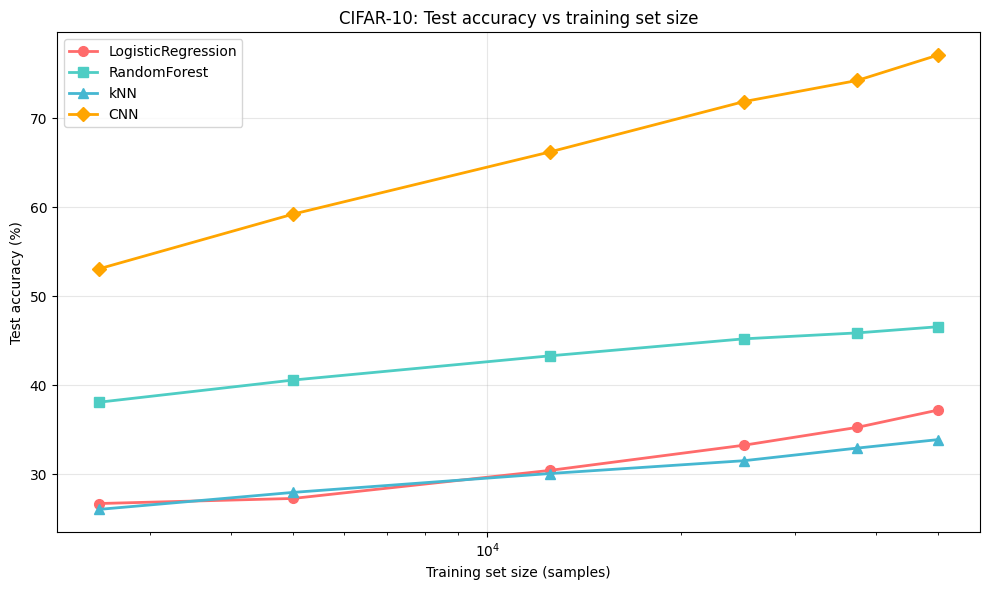

Saved learning_curves.png


In [9]:
plt.figure(figsize=(10, 6))
colors = {
    "LogisticRegression": "#FF6B6B",
    "RandomForest": "#4ECDC4",
    "kNN": "#45B7D1",
    "CNN": "#FFA500",
}
markers = {
    "LogisticRegression": "o",
    "RandomForest": "s",
    "kNN": "^",
    "CNN": "D",
}
for alg in ["LogisticRegression", "RandomForest", "kNN", "CNN"]:
    accs = [results[alg][f]["accuracy"] * 100 for f in fractions]
    xs = [int(f * 50000) for f in fractions]
    plt.plot(xs, accs,
             marker=markers[alg],
             color=colors[alg],
             linewidth=2,
             markersize=7,
             label=alg)

plt.xscale("log")
plt.xlabel("Training set size (samples)")
plt.ylabel("Test accuracy (%)")
plt.title("CIFAR-10: Test accuracy vs training set size")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("learning_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved learning_curves.png")
